In [1]:
import pandas as pd
import sqlite3
import numpy as np
from pprint import pprint
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
sql = '''
select SEASON, TEAM, ROUND, DATE, OPPONENT, XG, XGA
from TEAM_MATCH_LOG
where comp='Premier League' and season >'2017' and venue = 'Home'
order by season, date, team;
'''
with sqlite3.connect('../data/fpl.db') as con:
    match_data = pd.read_sql_query(sql, con)
match_data.head()

,SEASON,TEAM,ROUND,DATE,OPPONENT,XG,XGA
0,2017-2018,Arsenal,Matchweek 1,2017-08-11,Leicester City,2.5,1.5
1,2017-2018,Brighton,Matchweek 1,2017-08-12,Manchester City,0.3,1.9
2,2017-2018,Chelsea,Matchweek 1,2017-08-12,Burnley,1.5,0.6
3,2017-2018,Crystal Palace,Matchweek 1,2017-08-12,Huddersfield,1.1,1.5
4,2017-2018,Everton,Matchweek 1,2017-08-12,Stoke City,0.6,0.4


In [3]:
with sqlite3.connect('../data/fpl.db') as con:
    match_data = pd.read_sql_query(sql, con)
match_data.head()

,SEASON,TEAM,ROUND,DATE,OPPONENT,XG,XGA
0,2017-2018,Arsenal,Matchweek 1,2017-08-11,Leicester City,2.5,1.5
1,2017-2018,Brighton,Matchweek 1,2017-08-12,Manchester City,0.3,1.9
2,2017-2018,Chelsea,Matchweek 1,2017-08-12,Burnley,1.5,0.6
3,2017-2018,Crystal Palace,Matchweek 1,2017-08-12,Huddersfield,1.1,1.5
4,2017-2018,Everton,Matchweek 1,2017-08-12,Stoke City,0.6,0.4


In [4]:
def get_init_elo(match_data) :
    
    first_season = match_data.SEASON.min()    
    home_xg_mean = match_data.loc[match_data['SEASON'] == first_season].groupby('TEAM')['XG'].mean()
    home_xga_mean = match_data.loc[match_data['SEASON'] == first_season].groupby('TEAM')['XGA'].mean()
    away_xg_mean = match_data.loc[match_data['SEASON'] == first_season].groupby('OPPONENT')['XGA'].mean()
    away_xga_mean = match_data.loc[match_data['SEASON'] == first_season].groupby('OPPONENT')['XG'].mean()
    xg_mean = (home_xg_mean + away_xg_mean)/2
    xga_mean = (home_xga_mean + away_xga_mean)/2
    first_match = match_data.DATE.min()
    before_first_match = pd.to_datetime(first_match) - pd.DateOffset(days=1)
    first_season_elo = pd.DataFrame({
        'SEASON': first_season,
        'DATE': before_first_match.strftime('%Y-%m-%d'),
        'ATT_ELO': xg_mean, 
        'DEF_ELO': xga_mean, 
        'HOME_ATT_ELO': home_xg_mean, 
        'HOME_DEF_ELO': home_xga_mean, 
        'AWAY_ATT_ELO': away_xg_mean, 
        'AWAY_DEF_ELO': away_xga_mean  
    })
    first_season_elo.reset_index(inplace=True)
    first_season_elo.rename(columns={'index': 'TEAM'}, inplace=True)
    return first_season_elo

In [5]:
def find_promoted_relegated(match_data, curr_season, prev_season) :
    prev_teams = match_data[match_data.SEASON == prev_season].TEAM.unique().tolist()
    curr_teams = match_data[match_data.SEASON == curr_season].TEAM.unique().tolist()
    promoted = [team for team in curr_teams if team not in prev_teams]
    relegated = [team for team in prev_teams if team not in curr_teams]
    return promoted, relegated

seasons = sorted(match_data.SEASON.unique().tolist())
promotions = {}
relegations = {}
for prev_season, curr_season in zip(seasons, seasons[1:]):
    promotions[curr_season], relegations[curr_season] = find_promoted_relegated(match_data, curr_season, prev_season)
pprint(promotions)
pprint(relegations)

{'2018-2019': ['Fulham', 'Wolves', 'Cardiff City'],
 '2019-2020': ['Aston Villa', 'Norwich City', 'Sheffield Utd'],
 '2020-2021': ['Fulham', 'West Brom', 'Leeds United'],
 '2021-2022': ['Brentford', 'Norwich City', 'Watford']}
{'2018-2019': ['West Brom', 'Stoke City', 'Swansea City'],
 '2019-2020': ['Fulham', 'Huddersfield', 'Cardiff City'],
 '2020-2021': ['Bournemouth', 'Watford', 'Norwich City'],
 '2021-2022': ['Fulham', 'West Brom', 'Sheffield Utd']}


In [6]:
def get_expected_xg(att_elo, home_away_att_elo, def_elo, home_away_def_elo, home_away_weight = 0.20 ) :
    expected_xg = (1-home_away_weight) * (att_elo+def_elo) + home_away_weight * (home_away_att_elo+home_away_def_elo)
    return expected_xg

def get_next_elo(curr_elo, actual_xg, expected_xg, learning_rate = 0.12) :
    updated_elo = curr_elo + learning_rate*(actual_xg - expected_xg)
    return updated_elo

def season_difference(season_1, season_2):
    year_1 = int(season_1.split("-")[0])
    year_2 = int(season_2.split("-")[0])
    return year_1-year_2

def get_latest_elos(elo_df, season, prev_season, team):
    same_team = (elo_df.TEAM == team)
    within_2_seasons = (elo_df.SEASON.isin([season, prev_season]))
    matched = elo_df.loc[same_team & within_2_seasons]
    elo_cols = ["ATT_ELO", "DEF_ELO", "HOME_ATT_ELO", "HOME_DEF_ELO", "AWAY_ATT_ELO", "AWAY_DEF_ELO"]
    if len(matched) == 0:
        assert team in promotions[season]
        relegated_teams = elo_df.TEAM.isin(relegations[season])
        is_prev_season = elo_df.SEASON == prev_season
        matched = elo_df.loc[relegated_teams & is_prev_season].drop_duplicates("TEAM", keep="last")
        latest_elos = matched.loc[:, elo_cols].mean()
    else:
        latest_elos = matched.drop_duplicates("TEAM", keep="last").iloc[0]
        latest_elos = latest_elos.loc[elo_cols]
    return latest_elos

In [7]:
elo_df = get_init_elo(match_data)
first_season = seasons[0]
for idx, row in tqdm(match_data.iterrows(), total=match_data.shape[0]):
    curr_idx = seasons.index(row.SEASON)
    prev_season = seasons[curr_idx-1]
    home_team_elos = get_latest_elos(elo_df, row.SEASON, prev_season, row.TEAM)
    away_team_elos = get_latest_elos(elo_df, row.SEASON, prev_season, row.OPPONENT)
        
    expected_xg = get_expected_xg(home_team_elos.ATT_ELO, home_team_elos.HOME_ATT_ELO, away_team_elos.DEF_ELO, away_team_elos.AWAY_DEF_ELO)
    expected_xga = get_expected_xg(away_team_elos.ATT_ELO, away_team_elos.AWAY_ATT_ELO, home_team_elos.DEF_ELO, home_team_elos.HOME_DEF_ELO)
    
    next_home_team_elos = {
        "TEAM": row.TEAM, "SEASON": row.SEASON, "DATE": row.DATE,
        "ATT_ELO": get_next_elo(home_team_elos.ATT_ELO, row.XG, expected_xg),
        "DEF_ELO": get_next_elo(home_team_elos.DEF_ELO, row.XGA, expected_xga),
        "HOME_ATT_ELO": get_next_elo(home_team_elos.HOME_ATT_ELO, row.XG, expected_xg),
        "HOME_DEF_ELO": get_next_elo(home_team_elos.HOME_DEF_ELO, row.XGA, expected_xga),
        "AWAY_ATT_ELO": home_team_elos.AWAY_ATT_ELO,
        "AWAY_DEF_ELO": home_team_elos.AWAY_DEF_ELO
    }
    next_home_team_elos = pd.DataFrame(next_home_team_elos, index=[0])
    elo_df = pd.concat([elo_df, next_home_team_elos], ignore_index=True)
    

    next_away_team_elos = {
        "TEAM": row.OPPONENT, "SEASON": row.SEASON, "DATE": row.DATE,
        "ATT_ELO": get_next_elo(away_team_elos.ATT_ELO, row.XGA, expected_xga
        ),
        "DEF_ELO": get_next_elo(away_team_elos.DEF_ELO, row.XG, expected_xg),
        "HOME_ATT_ELO": away_team_elos.HOME_ATT_ELO,
        "HOME_DEF_ELO": away_team_elos.HOME_DEF_ELO,
        "AWAY_ATT_ELO": get_next_elo(away_team_elos.AWAY_ATT_ELO, row.XGA, expected_xga),
        "AWAY_DEF_ELO": get_next_elo(away_team_elos.AWAY_DEF_ELO, row.XG, expected_xg)
    }
    next_away_team_elos = pd.DataFrame(next_away_team_elos, index=[0])
    elo_df = pd.concat([elo_df, next_away_team_elos], ignore_index=True)
elo_df

  0%|          | 0/1900 [00:00<?, ?it/s]

,TEAM,SEASON,DATE,ATT_ELO,DEF_ELO,HOME_ATT_ELO,HOME_DEF_ELO,AWAY_ATT_ELO,AWAY_DEF_ELO
0,Arsenal,2017-2018,2017-08-10,1.800000,1.257895,2.347368,1.094737,1.252632,1.421053
1,Bournemouth,2017-2018,2017-08-10,1.021053,1.555263,1.236842,1.468421,0.805263,1.642105
2,Brighton,2017-2018,2017-08-10,0.978947,1.334211,1.252632,1.157895,0.705263,1.510526
3,Burnley,2017-2018,2017-08-10,0.860526,1.344737,0.915789,1.273684,0.805263,1.415789
4,Chelsea,2017-2018,2017-08-10,1.423684,0.886842,1.584211,0.778947,1.263158,0.994737
...,...,...,...,...,...,...,...,...,...
3815,Wolves,2021-2022,2022-05-22,0.279602,1.179275,0.714887,0.989933,0.485768,1.670043
3816,Manchester City,2021-2022,2022-05-22,1.992792,0.071224,2.463671,0.178529,1.594911,0.513747
3817,Aston Villa,2021-2022,2022-05-22,0.551534,0.710226,1.233228,0.921109,0.207780,1.202567
3818,Norwich City,2021-2022,2022-05-22,0.156122,1.727831,0.739003,1.276928,0.402500,1.884691


In [91]:
import matplotlib.pyplot as plt
team = "Arsenal"
sql = f'''
select SEASON, TEAM, ROUND, DATE, OPPONENT, XG, XGA, VENUE, LINK
from TEAM_MATCH_LOG
where comp='Premier League' and season >'2017' and team = '{team}'
order by season, date, team;
'''
with sqlite3.connect('../data/fpl.db') as con:
    team_df = pd.read_sql_query(sql, con)
team_df = pd.merge(team_df, elo_df, on=['TEAM', 'DATE', 'SEASON'], how='left')
team_df = pd.merge(team_df, elo_df, left_on=['OPPONENT', 'DATE', 'SEASON'], right_on=['TEAM', 'DATE', 'SEASON'], how='left', suffixes=('','_OPP'))
team_df["ATT_TOTAL"] = team_df.ATT_ELO + team_df.DEF_ELO_OPP
team_df.loc[team_df.VENUE == "Home", "HOME_ATT_TOTAL"] = team_df.HOME_ATT_ELO + team_df.AWAY_DEF_ELO_OPP
team_df.loc[team_df.VENUE == "Away", "AWAY_ATT_TOTAL"] = team_df.AWAY_ATT_ELO + team_df.HOME_DEF_ELO_OPP
team_df["DEF_TOTAL"] = team_df.DEF_ELO + team_df.ATT_ELO_OPP
team_df.loc[team_df.VENUE == "Home", "HOME_DEF_TOTAL"] = team_df.HOME_DEF_ELO + team_df.AWAY_ATT_ELO_OPP
team_df.loc[team_df.VENUE == "Away", "AWAY_DEF_TOTAL"] = team_df.AWAY_DEF_ELO + team_df.HOME_ATT_ELO_OPP

colors = {
    'Arsenal': ('#EF0107', '#FFFFFF'),
    'Aston Villa': ('#95BFE5', '#490A3D'),
    'Brentford': ('#FFD700', '#000000'),
    'Brighton': ('#0057B8', '#FFFFFF'),
    'Bournemouth': ('#E62333', '#000000'),
    'Burnley': ('#6C1D45', '#99D6EA'),
    'Cardiff City': ('#0047A0', '#FFFFFF'),
    'Chelsea': ('#034694', '#DBA111'),
    'Crystal Palace': ('#1B458F', '#C4122E'),
    'Everton': ('#003399', '#FFFFFF'),
    'Fulham': ('#FFFFFF', '#000000'),
    'Huddersfield': ('#0073C2', '#FFFFFF'),
    'Leeds United': ('#FFCD00', '#1C2C5B'),
    'Leicester City': ('#0053A0', '#FDBE11'),
    'Liverpool': ('#C8102E', '#F6EB61'),
    'Manchester City': ('#6CABDD', '#1C2C5B'),
    'Manchester Utd': ('#E20E2D', '#FFE500'),
    'Newcastle Utd': ('#000000', '#FFFFFF'),
    'Norwich City': ('#00A650', '#FFF200'),
    'Sheffield Utd': ('#EE2737', '#FFFFFF'),
    'Southampton': ('#D71920', '#FFFFFF'),
    'Stoke City': ('#E03A3E', '#FFFFFF'),
    'Swansea City': ('#FFFFFF', '#000000'),
    'Tottenham': ('#001C58', '#FFFFFF'),
    'Watford': ('#FBEE23', '#ED2127'),
    'West Ham': ('#7A263A', '#FFFFFF'),
    'West Brom': ('#091453', '#FFFFFF'),
    'Wolves': ('#FDB913', '#231F20'),
}

team_df["OPPONENT_COLOR"] = team_df["OPPONENT"].map(lambda x: colors[x][0])
team_df

,SEASON,TEAM,ROUND,DATE,OPPONENT,XG,XGA,VENUE,LINK,ATT_ELO,...,HOME_DEF_ELO_OPP,AWAY_ATT_ELO_OPP,AWAY_DEF_ELO_OPP,ATT_TOTAL,HOME_ATT_TOTAL,AWAY_ATT_TOTAL,DEF_TOTAL,HOME_DEF_TOTAL,AWAY_DEF_TOTAL,OPPONENT_COLOR
0,2017-2018,Arsenal,Matchweek 1,2017-08-11,Leicester City,2.5,1.5,Home,https://fbref.com/en/squads/18bb7c10/2017-2018...,1.712589,...,1.031579,1.093011,1.423116,2.896232,3.683074,NaN,2.330758,2.064968,NaN,#0053A0
1,2017-2018,Arsenal,Matchweek 2,2017-08-19,Stoke City,1.5,0.7,Away,https://fbref.com/en/squads/18bb7c10/2017-2018...,1.527625,...,1.367667,0.637053,1.479916,2.730471,NaN,2.435334,1.559596,NaN,2.169007,#E03A3E
2,2017-2018,Arsenal,Matchweek 3,2017-08-27,Liverpool,0.6,3.1,Away,https://fbref.com/en/squads/18bb7c10/2017-2018...,1.347119,...,0.237783,1.603663,1.204968,1.897765,NaN,1.124944,2.797310,NaN,3.392741,#C8102E
3,2017-2018,Arsenal,Matchweek 4,2017-09-09,Bournemouth,2.2,0.6,Home,https://fbref.com/en/squads/18bb7c10/2017-2018...,1.278528,...,1.247802,0.481986,1.419283,2.390350,3.610650,NaN,1.363709,1.334287,NaN,#E62333
4,2017-2018,Arsenal,Matchweek 5,2017-09-17,Chelsea,1.4,0.8,Away,https://fbref.com/en/squads/18bb7c10/2017-2018...,1.250676,...,0.506670,0.964686,0.758503,1.629006,NaN,1.365979,1.456639,NaN,2.321231,#034694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,2021-2022,Arsenal,Matchweek 35,2022-05-01,West Ham,0.9,0.6,Away,https://fbref.com/en/squads/18bb7c10/2021-2022...,0.968160,...,0.635271,0.722305,1.594260,1.739796,NaN,1.386718,0.799070,NaN,1.600226,#7A263A
186,2021-2022,Arsenal,Matchweek 36,2022-05-08,Leeds United,2.5,0.5,Home,https://fbref.com/en/squads/18bb7c10/2021-2022...,0.980215,...,0.561714,0.402611,1.939519,2.037492,3.968287,NaN,0.742871,1.054641,NaN,#FFCD00
187,2021-2022,Arsenal,Matchweek 22,2022-05-12,Tottenham,0.6,3.0,Away,https://fbref.com/en/squads/18bb7c10/2021-2022...,0.904122,...,0.346750,0.972304,0.735476,1.096875,NaN,1.022105,1.549754,NaN,2.883315,#001C58
188,2021-2022,Arsenal,Matchweek 37,2022-05-16,Newcastle Utd,0.7,1.7,Away,https://fbref.com/en/squads/18bb7c10/2021-2022...,0.817217,...,0.504475,0.410678,1.347027,1.289772,NaN,1.092924,0.982459,NaN,2.272382,#000000


In [126]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def plot_elos(team_df, x_axis, y_axis, color_by, tooltips):
    fig = make_subplots(rows=1, cols=3, shared_yaxes=True, subplot_titles=x_axis, y_title=y_axis,)
    for idx, axis in enumerate(x_axis):
        # px_figure = px.scatter(team_df, x=axis, y=y_axis, color=color_by, hover_data=["OPPONENT", "XG", "XGA"])
        # px_traces = px_figure["data"]
        # for trace in px_traces:
        #     fig.add_trace(trace, row=1, col=idx+1)
        fig.add_trace(
            go.Scatter(x=team_df[axis], 
                       y=team_df[y_axis], 
                       marker_color=team_df[color_by], 
                       text=team_df[tooltips].apply(lambda x: '\n'.join(x), axis=1),
                       showlegend=False
                       ),
            row=1, col=idx+1)
    fig.update_traces(mode='markers')
    fig.update_layout(height=400, width=1200)
    fig.update_layout(height=400, width=1200)
    fig.show()

plot_elos(team_df, ["ATT_TOTAL", "HOME_ATT_TOTAL", "AWAY_ATT_TOTAL"], "XG", "OPPONENT_COLOR", ["OPPONENT", "SEASON", "ROUND"])
plot_elos(team_df, ["DEF_TOTAL", "HOME_DEF_TOTAL", "AWAY_DEF_TOTAL"], "XG", "OPPONENT_COLOR")

TypeError: plot_elos() missing 1 required positional argument: 'tooltips'

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not ['Leicester City' 'Stoke City' 'Liverpool' 'Bournemouth' 'Chelsea'
 'West Brom' 'Brighton' 'Watford' 'Everton' 'Swansea City'
 'Manchester City' 'Tottenham' 'Burnley' 'Huddersfield' 'Manchester Utd'
 'Southampton' 'West Ham' 'Newcastle Utd' 'Liverpool' 'Crystal Palace'
 'West Brom' 'Chelsea' 'Bournemouth' 'Crystal Palace' 'Swansea City'
 'Everton' 'Tottenham' 'Manchester City' 'Brighton' 'Watford' 'Stoke City'
 'Southampton' 'Newcastle Utd' 'West Ham' 'Manchester Utd' 'Burnley'
 'Leicester City' 'Huddersfield' 'Manchester City' 'Chelsea' 'West Ham'
 'Cardiff City' 'Newcastle Utd' 'Everton' 'Watford' 'Fulham'
 'Leicester City' 'Crystal Palace' 'Liverpool' 'Wolves' 'Bournemouth'
 'Tottenham' 'Manchester Utd' 'Huddersfield' 'Southampton' 'Burnley'
 'Brighton' 'Liverpool' 'Fulham' 'West Ham' 'Chelsea' 'Cardiff City'
 'Manchester City' 'Huddersfield' 'Southampton' 'Bournemouth' 'Tottenham'
 'Manchester Utd' 'Newcastle Utd' 'Everton' 'Watford' 'Crystal Palace'
 'Wolves' 'Leicester City' 'Brighton' 'Burnley' 'Newcastle Utd' 'Burnley'
 'Liverpool' 'Tottenham' 'Watford' 'Aston Villa' 'Manchester Utd'
 'Bournemouth' 'Sheffield Utd' 'Crystal Palace' 'Wolves' 'Leicester City'
 'Southampton' 'Norwich City' 'Brighton' 'West Ham' 'Manchester City'
 'Everton' 'Bournemouth' 'Chelsea' 'Manchester Utd' 'Crystal Palace'
 'Sheffield Utd' 'Chelsea' 'Burnley' 'Newcastle Utd' 'Everton' 'West Ham'
 'Manchester City' 'Brighton' 'Southampton' 'Norwich City' 'Wolves'
 'Leicester City' 'Tottenham' 'Liverpool' 'Aston Villa' 'Watford' 'Fulham'
 'West Ham' 'Liverpool' 'Sheffield Utd' 'Manchester City' 'Leicester City'
 'Manchester Utd' 'Aston Villa' 'Leeds United' 'Wolves' 'Tottenham'
 'Burnley' 'Southampton' 'Everton' 'Chelsea' 'Brighton' 'West Brom'
 'Crystal Palace' 'Newcastle Utd' 'Southampton' 'Manchester Utd' 'Wolves'
 'Aston Villa' 'Leeds United' 'Manchester City' 'Leicester City' 'Burnley'
 'Tottenham' 'West Ham' 'Liverpool' 'Sheffield Utd' 'Fulham' 'Everton'
 'Newcastle Utd' 'West Brom' 'Chelsea' 'Crystal Palace' 'Brighton'
 'Brentford' 'Chelsea' 'Manchester City' 'Norwich City' 'Burnley'
 'Tottenham' 'Brighton' 'Crystal Palace' 'Aston Villa' 'Leicester City'
 'Watford' 'Liverpool' 'Newcastle Utd' 'Manchester Utd' 'Everton'
 'Southampton' 'West Ham' 'Leeds United' 'Norwich City' 'Manchester City'
 'Burnley' 'Wolves' 'Brentford' 'Wolves' 'Watford' 'Leicester City'
 'Liverpool' 'Aston Villa' 'Crystal Palace' 'Brighton' 'Southampton'
 'Chelsea' 'Manchester Utd' 'West Ham' 'Leeds United' 'Tottenham'
 'Newcastle Utd' 'Everton']

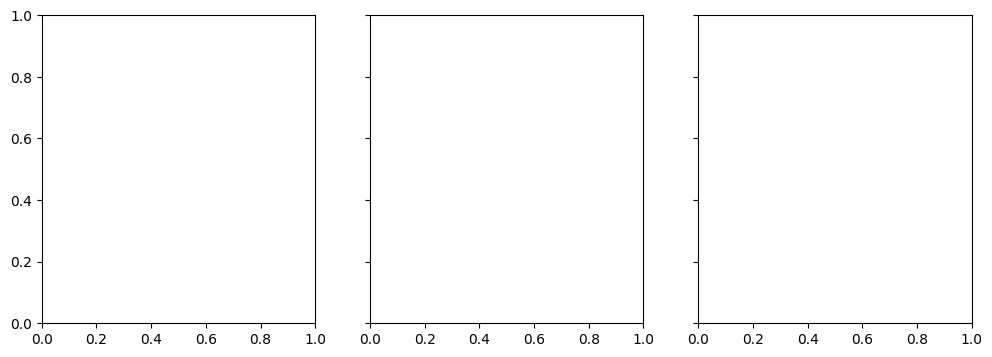

In [43]:
colors = {'A': 'red', 'B': 'blue'}

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), sharex='row', sharey='all')
team_df.plot(kind="scatter", x="ATT_TOTAL", y="XG", c="OPPONENT", ax=axs[0])
team_df.plot(kind="scatter", x="HOME_ATT_TOTAL", y="XG", c="OPPONENT", ax=axs[1])
team_df.plot(kind="scatter", x="AWAY_ATT_TOTAL", y="XG", c="OPPONENT", ax=axs[2])
plt.show()

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), sharex='row', sharey='all')
team_df.plot(kind="scatter", x="DEF_TOTAL", y="XGA", c="OPPONENT", ax=axs[0])
team_df.plot(kind="scatter", x="HOME_DEF_TOTAL", y="XGA", c="OPPONENT", ax=axs[1])
team_df.plot(kind="scatter", x="AWAY_DEF_TOTAL", y="XGA", c="OPPONENT", ax=axs[2])
plt.show()